# RNN 이중분류(스팸메일 데이터)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
data = pd.read_csv('spam.csv',encoding='latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data = data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [6]:
data.isnull().values.any()

False

In [7]:
print(data['v2'].nunique())   # 5572개 --> 5169개 => 중복샘플 403개 존재!
print(data['v1'].nunique())   # 0 또는 1 값만 가지므로 중복 X

5169
2


In [8]:
data.drop_duplicates(subset=['v2'],inplace=True)   # v2에서 중복이 있다면 제거
print(len(data))  # 중복제거한 총 데이터 개수

5169


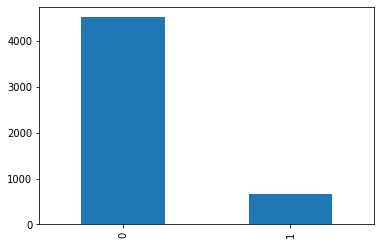

In [9]:
data['v1'].value_counts().plot(kind='bar')  # 대부분 정상 메일

In [10]:
# x와 y분리
X_data = data['v2']  # 입력
y_data = data['v1']  # 정답
print('메일 본문의 개수 : ',len(X_data))
print('레이블 개수: ',len(y_data))

메일 본문의 개수 :  5169
레이블 개수:  5169


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)  # 각각의 입력값 로우에 대해 토큰화 수행(단어별로 분리)
sequences = tokenizer.texts_to_sequences(X_data)  # 분리된 각 단어를 숫자값(인덱스)으로 변환
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [12]:
# 각 번호에는 어떤 단어가 배정되어있을까?
word_to_index = tokenizer.word_index
word_to_index
# 각 단어의 등장 빈도수 --> tokenizer.word_counts.items() 로 확인가능

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'it': 14,
 'of': 15,
 'have': 16,
 'call': 17,
 'that': 18,
 'on': 19,
 '2': 20,
 'are': 21,
 'now': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'can': 26,
 'at': 27,
 'or': 28,
 "i'm": 29,
 'do': 30,
 'be': 31,
 'get': 32,
 'will': 33,
 'just': 34,
 'if': 35,
 'with': 36,
 'we': 37,
 'no': 38,
 'this': 39,
 'ur': 40,
 'up': 41,
 'gt': 42,
 'lt': 43,
 '4': 44,
 'how': 45,
 'when': 46,
 'go': 47,
 'from': 48,
 'ok': 49,
 'out': 50,
 'all': 51,
 'what': 52,
 'free': 53,
 'know': 54,
 'like': 55,
 'then': 56,
 'got': 57,
 'good': 58,
 'come': 59,
 'am': 60,
 'was': 61,
 'time': 62,
 'its': 63,
 'only': 64,
 'day': 65,
 'want': 66,
 'love': 67,
 'there': 68,
 'he': 69,
 'text': 70,
 'send': 71,
 'going': 72,
 'one': 73,
 'need': 74,
 'by': 75,
 'lor': 76,
 'home': 77,
 'as': 78,
 'about': 79,
 'still': 80,
 'see': 81,
 'txt': 82,
 'back': 83,
 'r': 84,
 'sto

In [13]:
limit = 2
total_count = len(word_to_index)  # 총 단어의 수
rare_count = 0   # limit보다 등장 빈도수가 적은 단어 개수를 count
total_freq = 0  # 훈련데이터 전체 단어빈도수 총합
rare_freq = 0  # 등장빈도수가 limit보다 적은 단어의 등장 빈도수총합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if value < limit : 
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(limit - 1, rare_count))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 단어집합의 크기 제한 가능(등장 빈도가 1회인 단어 제거)
# ex) ----> tokenizer = Tokenizer(num_words= total_count - rare_count + 1)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


In [14]:
# 단어집합 vacab_size에 저장(따로 num_words 옵션 안 준 데이터로 시행)
vocab_size = len(word_to_index) + 1
# 패딩을 위한 토큰인 0번 단어를 고려해서 +1 해야함
print('단어집합 크기 : ',vocab_size)

단어집합 크기 :  8921


In [15]:
# train_test_split
n_of_train = int(len(sequences) * 0.8)  # 훈련데이터셋 80%
n_of_test = int(len(sequences) - n_of_train) # 테스트 데이터셋 20%

메일 최대 길이 :  189
메일 평균 길이 :  15.610369510543626


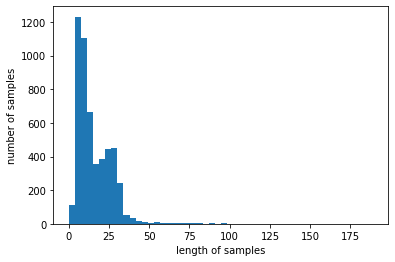

In [16]:
X_data = sequences
print('메일 최대 길이 : ',max(len(l) for l in X_data))
print('메일 평균 길이 : ',(sum(map(len,X_data)))/len(X_data))
plt.hist([len(s) for s in X_data],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 최대 메일길이 189
# 평균 메일길이 15.6
# 메일 평균분포는 대부분 50이하

In [17]:
max_len = 189  # 전체 데이터셋의 길이는 max_len으로 맞출것
data = pad_sequences(X_data,maxlen=max_len)
print('훈련데이터셋의 크기(shape) : ',data.shape)

# 모든 데이터셋(5169개)이 189의 크기를 갖게됨
# 189보다 메일 길이가 짧은 샘플은 숫자 0이 패딩되어 189의 길이를 갖는것

훈련데이터셋의 크기(shape) :  (5169, 189)


In [18]:
# train test 데이터셋 분류
X_train = data[:n_of_train]
y_train = np.array(y_data[:n_of_train]) 
X_test = data[n_of_train:]
y_test = np.array(y_data[n_of_train:])

In [19]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)  # validation_split = 0.2 --> 훈련 데이터 중 검증용 데이터

Epoch 1/4
52/52 [==============================] - 4s 48ms/step - loss: 0.3959 - acc: 0.8622 - val_loss: 0.1989 - val_acc: 0.9480
Epoch 2/4
52/52 [==============================] - 2s 42ms/step - loss: 0.1288 - acc: 0.9677 - val_loss: 0.0802 - val_acc: 0.9782
Epoch 3/4
52/52 [==============================] - 2s 42ms/step - loss: 0.2843 - acc: 0.8833 - val_loss: 0.1155 - val_acc: 0.9601
Epoch 4/4
52/52 [==============================] - 2s 44ms/step - loss: 0.0587 - acc: 0.9864 - val_loss: 0.0678 - val_acc: 0.9843


In [20]:
model.evaluate(X_test,y_test)
# 테스트 데이터셋에 대한 분류 정확도 : 98.16

33/33 [==============================] - 0s 10ms/step - loss: 0.0656 - acc: 0.9816


[0.06559213250875473, 0.9816247820854187]

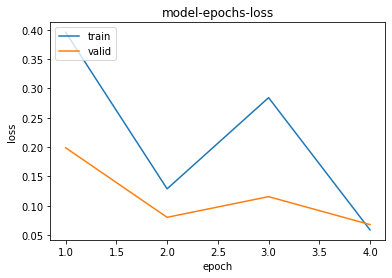

In [23]:
epochs = range(1,len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model-epochs-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'],loc='upper left')
plt.show()